# TEXAS05

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumulative_trapezoid
from pathlib import Path

In [2]:
EXPID = 'TEXAS05'
EXPTYPE = 'mfci'
DATE = '2015-10-13'

## Load Data

Fix for slightly 'broken' logger timeline

In [3]:
SRATE = 1.0e5
DURATION = 2.0
index = np.arange(DURATION * SRATE) / SRATE

In [4]:
folder = Path('../../data/sensors/')
file = next(folder.glob(f"*{EXPID}.txt"))
file

PosixPath('../../data/sensors/2015-10-13_TEXAS05.txt')

In [5]:
!head "../../data/sensors/2015-10-13_TEXAS05.txt"

t	Trigger	Kraft	Mikrophon	Elektrik	Seismik	shock-W	wasser
s	1V/V	1000N/V	1V/V	1V/V	1V/V	1Bar/V/V	1V/V
0.00000000 	0.20921844 	0.00308967 	-0.00141939 	0.20986260 	0.00373382 	-0.00560638 	8.32888198 
1.00000000E-5 	0.67397457 	0.00244552 	-0.00206355 	0.20889637 	0.00308967 	-0.00786092 	8.32855989 
2.00000000E-5 	1.29912523 	0.00341175 	-0.00174147 	0.20760806 	0.00276760 	-0.00689469 	8.32823780 
3.00000000E-5 	1.86726902 	0.00341175 	-0.00270770 	0.20696391 	0.00083514 	-0.00657261 	8.32855989 
4.00000000E-5 	2.39032279 	0.00308967 	-0.00077524 	0.20470938 	0.00212344 	-0.00753884 	8.32855989 
5.00000000E-5 	2.86957478 	0.00276760 	-0.00174147 	0.20309899 	0.00180137 	-0.00786092 	8.32823780 
6.00000000E-5 	3.30985608 	0.00341175 	-0.00141939 	0.20181069 	0.00212344 	-0.00689469 	8.32920407 
7.00000000E-5 	3.71631983 	0.00276760 	-0.00077524 	0.20020031 	0.00244552 	-0.00689469 	8.32823780 


In [6]:
data = pd.read_csv(file, skiprows=2, sep='\t',
    names=['trig', 'force', 'mic', 'el', 'seis', 'shockw', 'water'],
    index_col=0
)
data.index = index
data.index.name = 't'
data.force *= 1e3
data.shockw *= 1e5
data.head()

trig    force       mic        el      seis   shockw     water
t                                                                          
0.00000  0.209218  3.08967 -0.001419  0.209863  0.003734 -560.638  8.328882
0.00001  0.673975  2.44552 -0.002064  0.208896  0.003090 -786.092  8.328560
0.00002  1.299125  3.41175 -0.001741  0.207608  0.002768 -689.469  8.328238
0.00003  1.867269  3.41175 -0.002708  0.206964  0.000835 -657.261  8.328560
0.00004  2.390323  3.08967 -0.000775  0.204709  0.002123 -753.884  8.328560

In [7]:
units = ['s', 'V', 'N', 'V', 'V', 'V', 'Pa', 'V']

## Show Raw Data

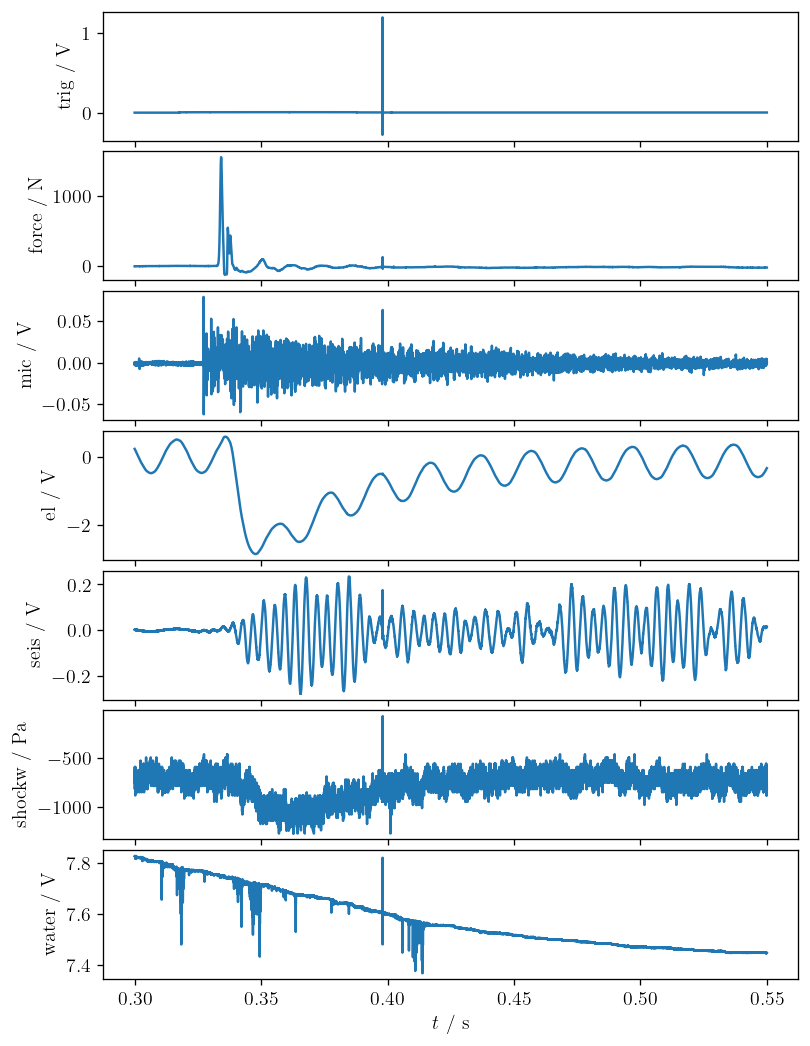

In [8]:
fig, axs = plt.subplots(nrows=data.shape[1], sharex=True)

for ax, col in zip(axs, data.columns):
    ax.plot(data.loc[0.3:.55, col])
axs[-1].set(xlabel=r'$t\ /\ \mathrm{s}$')
for ax, nm, unt in zip(axs, data.columns, units[1:]):
    ax.set_ylabel(f'{nm} / {unt}')
fig.set_size_inches(7, 9)
fig.tight_layout(pad=1, h_pad=0.)

- Mic caught a spike in important intervalnoisy

In [9]:
ttrig = 0.3177354
tspike = 0.5793447

## Summary Entries

In [10]:
fmax, fmin = data.loc[ttrig:0.39, 'force'].max(), data.loc[ttrig:.39, 'force'].min()
fmax, fmin

(1554.5321800000002, -116.72266)

### Summary

In [11]:
summ = pd.read_csv('../../data/summary.csv', index_col=0)
summ.loc[EXPID, 'exptype'] = EXPTYPE
summ.loc[EXPID, ['ttrig', 'tspike']] = [ttrig, tspike]
summ.loc[EXPID, ['Fmin', 'Fmax']] = fmin, fmax
summ

exptype     ttrig    tspike        Fmax       Fmin       pmax
expid                                                                     
H254-dry-01      dry  1.987832  2.497630   762.86770 -300.95020  3695707.0
H254-MFCI-03    ifci  1.987743  2.497569  1157.73400 -210.44680  4479971.0
billstein01     mfci  0.317654  0.579460   286.26030  -39.35883        NaN
billstein02     mfci  0.317585  0.579495   679.03260  -86.86507        NaN
billstein03     mfci  0.317615  0.579465   177.55950  -37.42638        NaN
billstein04     mfci  0.317574  0.579375  1996.81500 -122.13240        NaN
TEXAS01         mfci  0.317606  0.579475   321.62310  -75.17484        NaN
TEXAS02         mfci  0.317635  0.579426   971.89530 -110.92530        NaN
TEXAS03         mfci  0.317675  0.579365  1358.38700 -127.99530        NaN
TEXAS05         mfci  0.317735  0.579345  1554.53218 -116.72266        NaN

### asdf

In [12]:
import asdf

In [13]:
tree = {
    'id': EXPID,
    'date': DATE,
    'srate': SRATE,
    'summ': dict(summ.loc[EXPID]),
    'fields': ['t'] + list(data.columns),
    'units': units,
    'time': {'ttrig': ttrig, 'tspike': tspike, 't': data.index.values},
}
for col in data.columns:
    tree[col] = data[col].values
af = asdf.AsdfFile(tree)